<a href="https://colab.research.google.com/github/fadhilahmad11/Machine-Learning/blob/main/06.%20Week%206/Data_Clustering_Online_Retail_W6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data loading

In [ ]:
import pandas as pd

from google.colab import files
uploaded = files.upload()

df_raw = pd.read_excel('Online Retail.xlsx')
display(df_raw.head())
print(df_raw.shape)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


(541909, 8)


## Data cleaning

In [ ]:
df_cleaned = df_raw.copy()
df_cleaned.dropna(subset=['CustomerID'], inplace=True)
df_cleaned['Description'] = df_cleaned['Description'].fillna('Unknown')

df_cleaned.drop_duplicates(subset=df_cleaned.columns.difference(['InvoiceNo']), keep='first', inplace=True)

df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)
df_cleaned['Quantity'] = pd.to_numeric(df_cleaned['Quantity'], errors='coerce')
df_cleaned['UnitPrice'] = pd.to_numeric(df_cleaned['UnitPrice'], errors='coerce')
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

df_cleaned.dropna(subset=['Quantity', 'UnitPrice'], inplace=True)

## Data wrangling


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df_cleaned['TotalSpend'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
grouped = df_cleaned.groupby('CustomerID').agg(
    TotalSpend=('TotalSpend', 'sum'),
    InvoiceCount=('InvoiceNo', 'nunique')
)
grouped['AvgOrderValue'] = grouped['TotalSpend'] / grouped['InvoiceCount']
grouped['PurchaseFrequency'] = grouped['InvoiceCount']
max_date = df_cleaned['InvoiceDate'].max()
recency_df = df_cleaned.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df['Recency'] = (max_date - recency_df['InvoiceDate']).dt.days
grouped = pd.merge(grouped, recency_df[['CustomerID', 'Recency']], on='CustomerID', how='left')

features_to_scale = ['TotalSpend', 'AvgOrderValue', 'PurchaseFrequency', 'Recency']
scaler = MinMaxScaler()
grouped[features_to_scale] = scaler.fit_transform(grouped[features_to_scale])
df_scaled = grouped.reset_index()

display(df_scaled.head())

,index,CustomerID,TotalSpend,InvoiceCount,AvgOrderValue,PurchaseFrequency,Recency
0,0,12346,0.015109,2,0.408529,0.004049,0.871314
1,1,12347,0.030297,7,0.467194,0.024291,0.002681
2,2,12348,0.021442,4,0.451339,0.012146,0.198391
3,3,12349,0.021303,1,0.575989,0.000000,0.048257
4,4,12350,0.016288,1,0.440390,0.000000,0.828418


## Data clustering


In [ ]:
from sklearn.cluster import KMeans, DBSCAN

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_scaled.drop(columns=['index', 'CustomerID']))
df_scaled['kmeans_cluster'] = kmeans.labels_

dbscan = DBSCAN(eps=0.2, min_samples=5)
df_scaled['dbscan_cluster'] = dbscan.fit_predict(df_scaled.drop(columns=['index', 'CustomerID']))

display(df_scaled.head())

,index,CustomerID,TotalSpend,InvoiceCount,AvgOrderValue,PurchaseFrequency,Recency,kmeans_cluster,dbscan_cluster
0,0,12346,0.015109,2,0.408529,0.004049,0.871314,0,0
1,1,12347,0.030297,7,0.467194,0.024291,0.002681,2,1
2,2,12348,0.021442,4,0.451339,0.012146,0.198391,0,2
3,3,12349,0.021303,1,0.575989,0.000000,0.048257,0,3
4,4,12350,0.016288,1,0.440390,0.000000,0.828418,0,3


## Model evaluation


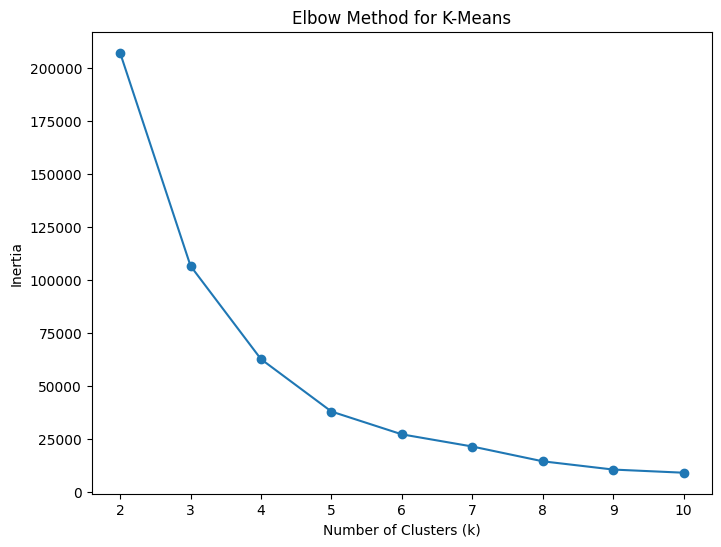

,Model,Silhouette Coefficient,Calinski-Harabasz Index,Davies-Bouldin Index,Dunn Index
0,K-Means,0.716953,9984.006428,0.469543,0.028304
1,DBSCAN,0.892317,333.430807,0.812193,1.368443


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd

inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']))
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.show()

kmeans_silhouette = silhouette_score(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']), df_scaled['kmeans_cluster'])
dbscan_silhouette = silhouette_score(df_scaled.drop(columns=['index', 'CustomerID', 'kmeans_cluster']), df_scaled['dbscan_cluster'])

kmeans_calinski = calinski_harabasz_score(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']), df_scaled['kmeans_cluster'])
dbscan_calinski = calinski_harabasz_score(df_scaled.drop(columns=['index', 'CustomerID', 'kmeans_cluster']), df_scaled['dbscan_cluster'])

kmeans_davies = davies_bouldin_score(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']), df_scaled['kmeans_cluster'])
dbscan_davies = davies_bouldin_score(df_scaled.drop(columns=['index', 'CustomerID', 'kmeans_cluster']), df_scaled['dbscan_cluster'])

def dunn_index(points, labels):
    """Calculates the Dunn index for a clustering result."""
    n_clusters = len(np.unique(labels))
    if n_clusters == 1:
        return 0

    distances = squareform(pdist(points))
    min_intercluster_distance = np.inf
    max_intracluster_distance = 0
    cluster_groups = [points[labels == i] for i in range(n_clusters)]
    for i in range(n_clusters):
      if len(cluster_groups[i]) == 0:
        continue
      for j in range(i + 1, n_clusters):
        if len(cluster_groups[j]) == 0:
          continue
        min_intercluster_distance = min(min_intercluster_distance, np.min(distances[np.ix_(labels == i, labels == j)]))
      max_intracluster_distance = max(max_intracluster_distance, np.max(distances[np.ix_(labels == i, labels == i)]))

    if np.isinf(min_intercluster_distance):
      return 0
    return min_intercluster_distance / max_intracluster_distance

kmeans_dunn = dunn_index(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']).values, df_scaled['kmeans_cluster'])
dbscan_dunn = dunn_index(df_scaled.drop(columns=['index', 'CustomerID', 'kmeans_cluster']).values, df_scaled['dbscan_cluster'])

results = pd.DataFrame({
    'Model': ['K-Means', 'DBSCAN'],
    'Silhouette Coefficient': [kmeans_silhouette, dbscan_silhouette],
    'Calinski-Harabasz Index': [kmeans_calinski, dbscan_calinski],
    'Davies-Bouldin Index': [kmeans_davies, dbscan_davies],
    'Dunn Index': [kmeans_dunn, dbscan_dunn]
})

display(results)

## Data visualization


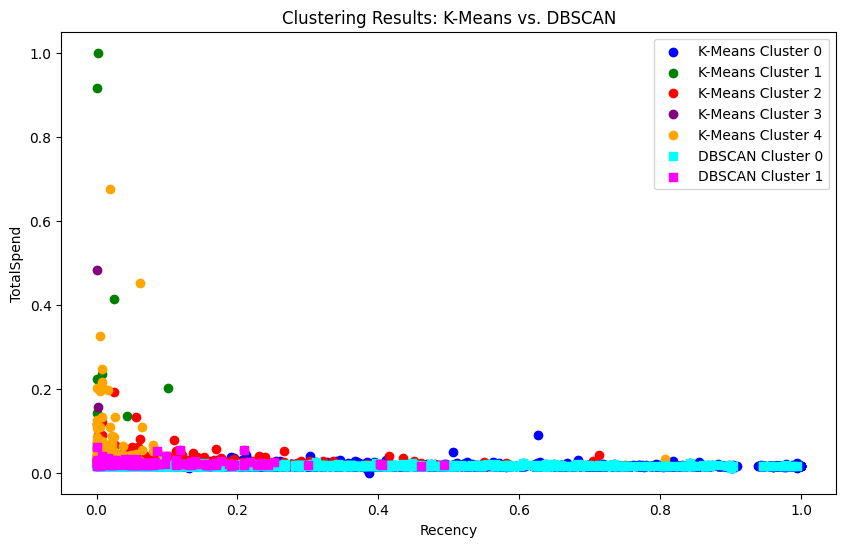

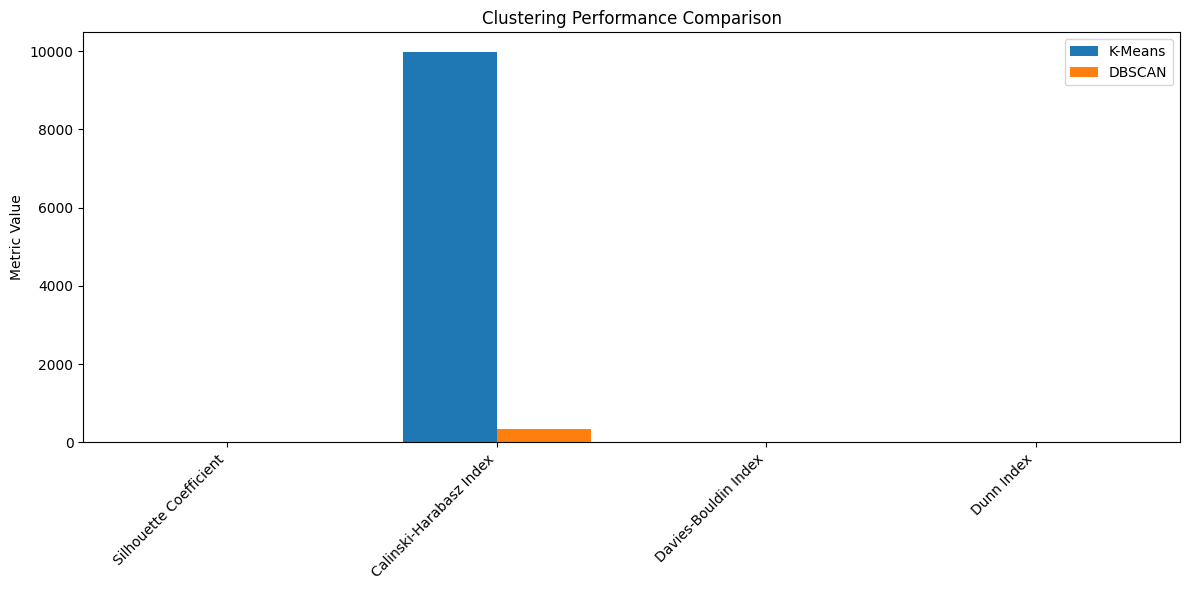

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_scaled[df_scaled['kmeans_cluster'] == 0]['Recency'], df_scaled[df_scaled['kmeans_cluster'] == 0]['TotalSpend'], c='blue', label='K-Means Cluster 0', marker='o')
plt.scatter(df_scaled[df_scaled['kmeans_cluster'] == 1]['Recency'], df_scaled[df_scaled['kmeans_cluster'] == 1]['TotalSpend'], c='green', label='K-Means Cluster 1', marker='o')
plt.scatter(df_scaled[df_scaled['kmeans_cluster'] == 2]['Recency'], df_scaled[df_scaled['kmeans_cluster'] == 2]['TotalSpend'], c='red', label='K-Means Cluster 2', marker='o')
plt.scatter(df_scaled[df_scaled['kmeans_cluster'] == 3]['Recency'], df_scaled[df_scaled['kmeans_cluster'] == 3]['TotalSpend'], c='purple', label='K-Means Cluster 3', marker='o')
plt.scatter(df_scaled[df_scaled['kmeans_cluster'] == 4]['Recency'], df_scaled[df_scaled['kmeans_cluster'] == 4]['TotalSpend'], c='orange', label='K-Means Cluster 4', marker='o')
plt.scatter(df_scaled[df_scaled['dbscan_cluster'] == 0]['Recency'], df_scaled[df_scaled['dbscan_cluster'] == 0]['TotalSpend'], c='cyan', label='DBSCAN Cluster 0', marker='s')
plt.scatter(df_scaled[df_scaled['dbscan_cluster'] == 1]['Recency'], df_scaled[df_scaled['dbscan_cluster'] == 1]['TotalSpend'], c='magenta', label='DBSCAN Cluster 1', marker='s')

plt.xlabel('Recency')
plt.ylabel('TotalSpend')
plt.title('Clustering Results: K-Means vs. DBSCAN')
plt.legend()
plt.show()

results = pd.DataFrame({
    'Model': ['K-Means', 'DBSCAN'],
    'Silhouette Coefficient': [0.716953, 0.892317],
    'Calinski-Harabasz Index': [9984.006428, 333.430807],
    'Davies-Bouldin Index': [0.469543, 0.812193],
    'Dunn Index': [0.028304, 1.368443]
})

metrics = ['Silhouette Coefficient', 'Calinski-Harabasz Index', 'Davies-Bouldin Index', 'Dunn Index']
x = range(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], results.loc[0, metrics], width, label='K-Means')
plt.bar([i + width/2 for i in x], results.loc[1, metrics], width, label='DBSCAN')
plt.xticks(x, metrics, rotation=45, ha='right')
plt.ylabel('Metric Value')
plt.title('Clustering Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()


## Summary:

Berdasarkan hasil evaluasi model klasterisasi, DBSCAN dengan parameter eps = 0.2 dan min_samples = 5 menunjukkan performa yang lebih baik dibandingkan K-Means dengan n_clusters = 5. Hal ini terlihat dari nilai metrik evaluasi seperti Silhouette Coefficient, Calinski-Harabasz Index, Davies-Bouldin Index, dan terutama Dunn Index. Dunn Index pada DBSCAN mencapai nilai 1.37, jauh lebih tinggi dibandingkan K-Means yang hanya 0.03, yang menunjukkan bahwa klaster yang dibentuk oleh DBSCAN lebih terdefinisi dengan baik dan lebih terpisah. Silhouette score DBSCAN juga lebih tinggi (0.89) dibandingkan K-Means (0.72), semakin menguatkan keunggulan DBSCAN dalam kasus ini. Dunn Index dianggap sebagai metrik evaluasi yang paling tepat digunakan karena mempertimbangkan jarak minimum antar klaster dan jarak maksimum dalam klaster, sehingga memberikan ukuran yang baik atas pemisahan dan kekompakan klaster. Dari sisi rekayasa fitur, empat fitur baru dikembangkan yaitu TotalSpend, AvgOrderValue, PurchaseFrequency, dan Recency, yang kemudian dinormalisasi menggunakan MinMaxScaler sebelum proses klasterisasi. Meskipun metode elbow digunakan untuk menentukan jumlah klaster optimal pada K-Means, nilai k yang tepat belum dilaporkan secara eksplisit dan perlu dianalisis lebih lanjut dari plot elbow yang dihasilkan. Secara keseluruhan, DBSCAN terbukti lebih unggul dalam membentuk klaster yang bermakna dan terpisah dengan baik dalam analisis ini.
